In [2]:
featured_model = 'Time_22050_1'

In [3]:
from DataLoad import load_to_dataframe
df, df_raw, class_dict = load_to_dataframe()

In [41]:
from feature_generator import create_features
features, labels = create_features(df_raw, featured_model + ".txt")

Time_22050_1.txt
Features already calculated, read from disc, ignore parameter file


In [47]:
# Move channels first for Kapre
features = np.moveaxis(features, 1, 2)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.3)

In [49]:
from BatchGenerators import SoundSequence
batch_size = 30
train_gen = SoundSequence(X_train, y_train, batch_size)
test_gen = SoundSequence(X_test, y_test, batch_size)

In [51]:
X_train.shape

(1, 66150)

In [39]:
import numpy as np
number_of_classes = len(np.unique(labels))

In [82]:
# Model with Kapre layers 
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Spectrogram, Melspectrogram
from kapre.filterbank import Filterbank
from kapre.augmentation import AdditiveNoise

input_shape = X_train[0].shape
SR = 22050

model = Sequential()
#model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=X_train[0].shape,
#                      return_decibel_spectrogram=True, power_spectrogram=2.0, trainable_kernel=False, name='static_stft'))
model.add(Melspectrogram(sr=SR, n_mels=128, 
          n_dft=512, n_hop=256, input_shape=input_shape, 
          return_decibel_melgram=True,
          trainable_kernel=True, name='melgram'))
#model.add(Spectrogram(n_dft=1024, n_hop=256, input_shape=inpute_shape, return_decibel_spectrogram=True, power_spectrogram=2.0, 
#          trainable_kernel=True, name='trainable_stft'))
model.add(AdditiveNoise(power=0.2, random_gain=True))
#model.add(Filterbank(n_fbs=60, trainable_fb=False, sr=SR, init='log', fmin=None, fmax=SR//2, bins_per_octave=12, name='log_bank'))
model.add(Filterbank(n_fbs=50, trainable_fb=True, sr=SR, init='mel', fmin=0, fmax=SR//2, bins_per_octave=12, name='mel_bank'))
model.add(layers.Conv2D(32, (3, 3), name='conv1', activation='relu'))
model.add(layers.MaxPooling2D((25, 17)))
model.add(layers.Dropout2D(0.3))
#model.add(layers.Conv2D(32, (10, 10), name='conv2', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(11, activation='softmax'))
model.summary()#line_length=80, positions=[.33, .65, .8, 1.])
#visualise_model(model)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 259, 1)       296064    
_________________________________________________________________
additive_noise_17 (AdditiveN (None, 128, 259, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 257, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 15, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                26411     
Total params: 322,795
Trainable params: 322,795
Non-trainable params: 0
_______________________________________________

NameError: name 'visualise_model' is not defined

In [84]:
optimizer = 'adam'
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [85]:
epochs = 30
history = model.fit(
    train_gen,
#    steps_per_epoch=30,
    epochs=epochs,
    validation_data=test_gen,
#    validation_steps=30
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 157 steps, validate for 68 steps
Epoch 1/30
157/157 [==============================] - 72s 459ms/step - loss: 21.0983 - accuracy: 0.1031 - val_loss: 9.2354 - val_accuracy: 0.1168
Epoch 2/30
157/157 [==============================] - 70s 446ms/step - loss: 7.0357 - accuracy: 0.1274 - val_loss: 5.7087 - val_accuracy: 0.1446
Epoch 3/30
157/157 [==============================] - 71s 454ms/step - loss: 5.3018 - accuracy: 0.1370 - val_loss: 4.2246 - val_accuracy: 0.1292
Epoch 4/30
157/157 [==============================] - 72s 458ms/step - loss: 4.0571 - accuracy: 0.1536 - val_loss: 3.5111 - val_accuracy: 0.1377
Epoch 5/30
157/157 [==============================] - 69s 442ms/step - loss: 3.5382 - accuracy: 0.1617 - val_loss: 3.3675 - val_accuracy: 0.1551
Epoch 6/30
157/157 [==============================] - 72s 462ms/step - loss: 3.0228 - accuracy: 0.1671 - val_loss: 3.0220 - val_accuracy: 0.1610
Epoch 7/30
157/157 [================

KeyboardInterrupt: 

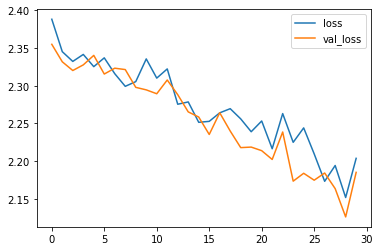

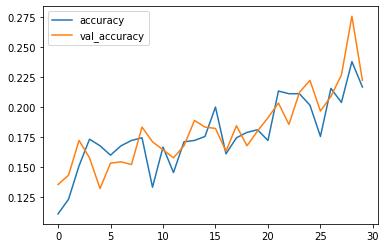

In [10]:
from PlotModel import plot_model_history
plot_model_history(model)

In [13]:
model.save('saved_models/' + featured_model + ".mdl") 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/Mel_Linear_1_Param.mdl/assets
